In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import KeyedVectors
import pickle
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

e:\Bootcamp\NLP_Grupo3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ejecutar el código siguiente si es la primera vez que se trabaja con nltk. Si no dejarlo comentado

In [ ]:
# nltk.download('stopwords')
# nltk.download('punkt_tab')
# nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /home/carri/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Cargar el conjunto de datos

In [6]:
df = pd.read_csv('../database/toxic.csv')

### Procesar texto

Para que se haga una mejor predicción usamos los vectores pre entrenados de GloVe, de tal forma que aseguramos la representatividad de los vectores extraidos del texto con embeddings.

Primero definimos una función para cargar estos embeddings, que provienen de un archivo de texto que hay que descargar de https://nlp.stanford.edu/projects/glove/ aqui estamos usando el de twitter de 100d.

Se genera un índice de embeddings con el contenido del txt que hemos descargado y después hay que procesar el texto. La función viene con pasos detallados, se puede encontrar más información sobre el stemming aqui: https://www.ibm.com/es-es/topics/stemming

Despues de procesar el texto se pasa a embeddings utilizando el indice que hemos extraido del archivo de GloVe. La idea es convertir la lista de tokens (palabras) que hemos extraido del texto de la base de datos a un vector que represente el significado semántico de la palabra, para ello se hace una media de los embeddings de los tokens del texto.

La mejor forma de entender los embeddings es echar mano de algebra matricial y ver como funciona el sumatorio de matrices y vectores.

In [7]:
def load_glove_embeddings(file_path):
    embedding_index = {}
    with open(file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
    return embedding_index

def procesar_texto(text):
    '''
    1. El texto se pasa todo a minúsculas
    2. Se eliminan todos los símbolos que pueden dar problemas
    3. Se tokeniza el texto
    4. Se eliminan las stop_words, básicamente preposiciones o palabras que no aportan contenido semántico, a excepción de las negaciones porque pueden dar información conrextual relevante.
    5. Se convierten los tokens mediantes stemming, que se queda con la raiz o "lema" de una palabra para mejorar el rendimiento
    '''
    text = text.lower() 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
    tokens = [token for token in tokens if token not in stop_words]

    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def text_to_embedding(tokens, embeddings_index, embedding_dim=100):
    '''
    1. Se inicializa el embedding (vector) vacío pero con las dimensiones especificadas (100, que coincide con las dimensiones de los embeddings descargados)
    Este vector guarda el sumatorio acumulado de cada embedding individual de cada palabra (de 100 dimensiones también), que representará el texto completo.
    2. Se inicia un conteo a 0, este conteo servirá para contar cuantos embeddings válidos encontramos en el índice, y si no hay se mantiene a 0 para prevenir errores futuros al dividir.
    3. Se itera sobre la lista de tokens del texto y si se encuentra el token en el índice de embeddings, se añade el vector de la palabra al vector de embedding. Cada vez que encuentra una válido se suma 1 al conteo.
    4. Por último se saca la media del embedding con el número de conteo para que las palabras más representadas en un texto no dominen el embedding final.
    '''
    embedding = np.zeros(embedding_dim)
    count = 0
    for token in tokens:
        if token in embeddings_index:
            embedding += embeddings_index[token]
            count += 1
    if count > 0:
        embedding /= count
    return embedding

df['Text'] = df['Text'].apply(procesar_texto)

glove_path = '../assets/glove.twitter.27B.100d.txt' # Archivo descargado de embeddings
embeddings_index = load_glove_embeddings(glove_path)

# Texto procesado a embedding
embedding_dim = 100
X = np.array([text_to_embedding(tokens, embeddings_index, embedding_dim) for tokens in df['Text']])

y = df['IsToxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1337)

eval_set = [(X_train, y_train), (X_test, y_test)]

Versión usando BERT

In [2]:
df = pd.read_csv('../database/toxic.csv')

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def procesar_texto(text):
    '''
    1. El texto se pasa todo a minúsculas
    2. Se eliminan todos los símbolos que pueden dar problemas
    3. Se tokeniza el texto
    4. Se eliminan las stop_words, básicamente preposiciones o palabras que no aportan contenido semántico, a excepción de las negaciones porque pueden dar información conrextual relevante.
    5. Se convierten los tokens mediantes stemming, que se queda con la raiz o "lema" de una palabra para mejorar el rendimiento
    '''
    text = text.lower() 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
    tokens = [token for token in tokens if token not in stop_words]

    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

def text_to_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings.flatten()

df['Text'] = df['Text'].apply(procesar_texto)

X = np.array([text_to_embedding(text, model, tokenizer) for text in df['Text']])
y = df['IsToxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1337)

eval_set = [(X_train, y_train), (X_test, y_test)]

e:\Bootcamp\NLP_Grupo3\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alberto\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


### Definir busqueda de hiperparametros con optuna

Se definen los parametros a buscar por optuna y se incluye una estratificación de K_folds para evitar el sobreajuste del modelo.

Al final del documento vienen las instrucciones para cargarlo del archivo pkl si no se quiere reentrenar

In [4]:
def objective(trial, n_splits = 5):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
            'random_state': 42,
            'eval_metric': 'logloss'
        }
    
    skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 1337)
    scores = []

    for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Entrenar modelo
            model = XGBClassifier(**params, early_stopping_rounds = 50)
            model.fit(
                X_train, y_train,
                eval_set=[(X_test, y_test)],
                verbose=False
            )
            
            # Evaluar
            pred = model.predict(X_test)
            scores.append(accuracy_score(y_test, pred))
        
    return np.mean(scores)

In [5]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

best_params = study.best_params

[I 2024-11-17 18:33:33,426] A new study created in memory with name: no-name-578919d7-09a8-4dfa-a5af-a8fc9550af6e
[I 2024-11-17 18:33:56,223] Trial 0 finished with value: 0.6860000000000002 and parameters: {'n_estimators': 611, 'learning_rate': 0.05519329832540963, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.3000612436486172, 'subsample': 0.9639517507559856, 'colsample_bytree': 0.7620985423979352, 'reg_alpha': 0.029713055260362248, 'reg_lambda': 0.006938297563707279}. Best is trial 0 with value: 0.6860000000000002.
[I 2024-11-17 18:34:08,378] Trial 1 finished with value: 0.639 and parameters: {'n_estimators': 977, 'learning_rate': 0.29359942125880717, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.1629721031852069, 'subsample': 0.9957504742349701, 'colsample_bytree': 0.702229801553527, 'reg_alpha': 0.02143225489552086, 'reg_lambda': 0.0013641544259724062}. Best is trial 0 with value: 0.6860000000000002.
[I 2024-11-17 18:34:22,588] Trial 2 finished with value: 0.676999999999999

In [6]:
final_model = XGBClassifier(**best_params)
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8421603625983605, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None,
              gamma=1.3728961529849679e-08, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05149876320947211, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=794, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
y_pred_final = final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

# Se vuelve a comprobar el overfitting con cross validation
cv_scores = cross_val_score(final_model, X, y, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

conf_matrix = confusion_matrix(y_test, y_pred_final)
class_report = classification_report(y_test, y_pred_final)

Puntajes de validación cruzada: [0.725 0.655 0.71  0.7   0.63 ]
Media de los puntajes: 0.6839999999999999


#### Gráficos de evaluación de rendimiento del modelo

Precisión del modelo: 1.0


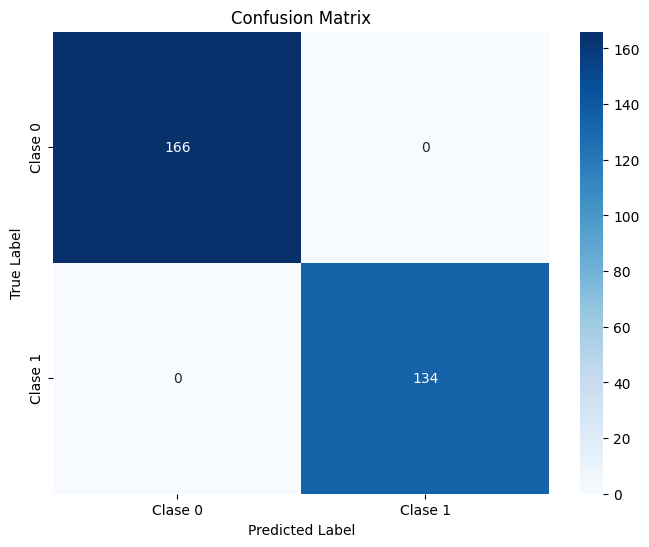

Reporte de clasificación:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       166
        True       1.00      1.00      1.00       134

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



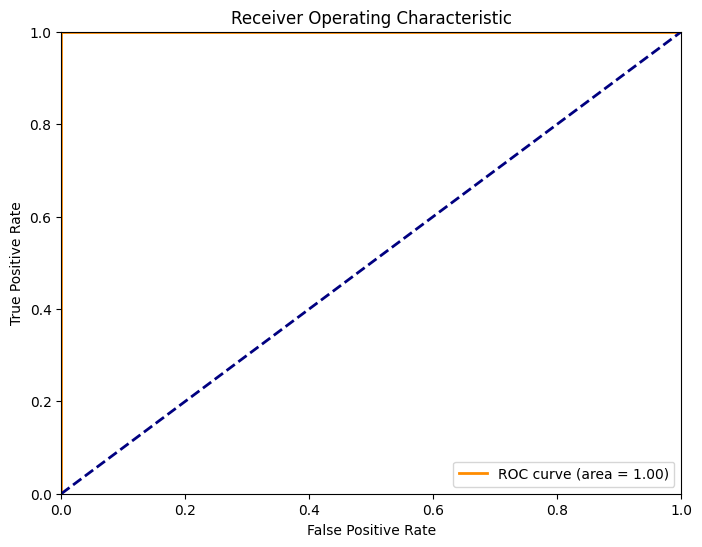

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_final}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
def preprocess_and_embed(text, embeddings_index, embedding_dim=100):
    # Preprocesa el texto
    tokens = procesar_texto(text)
    # Convierte el texto en los embeddings como vimos en el princpio
    embedding = text_to_embedding(tokens, embeddings_index, embedding_dim)
    return np.array([embedding])  # Devuelve un array 2d para las predicciones

Versión para BERT

In [10]:
def preprocess_and_embed(text, model, tokenizer):
    text = procesar_texto(text)
    
    # Convierte el texto en embeddings usando BERT
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    
    return embeddings.flatten()

Probamos un texto evidente que contiene hate speech para comprobar que funciona

In [ ]:
text = 'I hate your face you fucking idiot'

processed_text= preprocess_and_embed(text, embeddings_index, embedding_dim=100)

prediction = final_model.predict(processed_text)[0]
proba = final_model.predict_proba(processed_text)[0][1]

print(prediction)
print(proba)

In [29]:
text = 'Black people should not be killed'

embedding = preprocess_and_embed(text, model, tokenizer)

prediction = final_model.predict([embedding])[0]
proba = final_model.predict_proba([embedding])[0][1]

print(prediction)
print(proba)

0
0.26118556


In [18]:
def save_model(model, file_path):
    """
    Salvar el modelo en un pickle
    """
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)

In [54]:
save_model(final_model, 'final_model.pkl')

In [19]:
save_model(final_model, 'final_model_BERT.pkl')

In [55]:
def load_model(file_path):
    with open(file_path, 'rb') as file:
        model = pickle.load(file)
    return model

In [56]:
loaded_model = load_model('final_model.pkl')